In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import plotly.express as px

In [3]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [4]:
ozone_csv = pd.read_csv("Monthly mean thickness Dobson units ozone column Arosa Switzerland 192.csv")
ozone_csv.rename(columns={'Unnamed: 0':'t'}, inplace=True)
ozone_csv = ozone_csv.interpolate()
ozone_csv.head()

,t,x
0,1,312.0
1,2,300.0
2,3,281.0
3,4,267.0
4,5,295.0


In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [6]:
n_vars = 1 if type(ozone_csv) is list else ozone_csv.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(ozone_csv.shift(i))
for i in range(0, 1):
    cols.append(ozone_csv.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [7]:
len(list_for_forecast)

545

In [8]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [9]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [10]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  26.200556520540395


In [11]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 31.363638270671192
MAPE: 0.07822297185763709
MAE: 26.200556520540395
R2:  0.3262796279329193


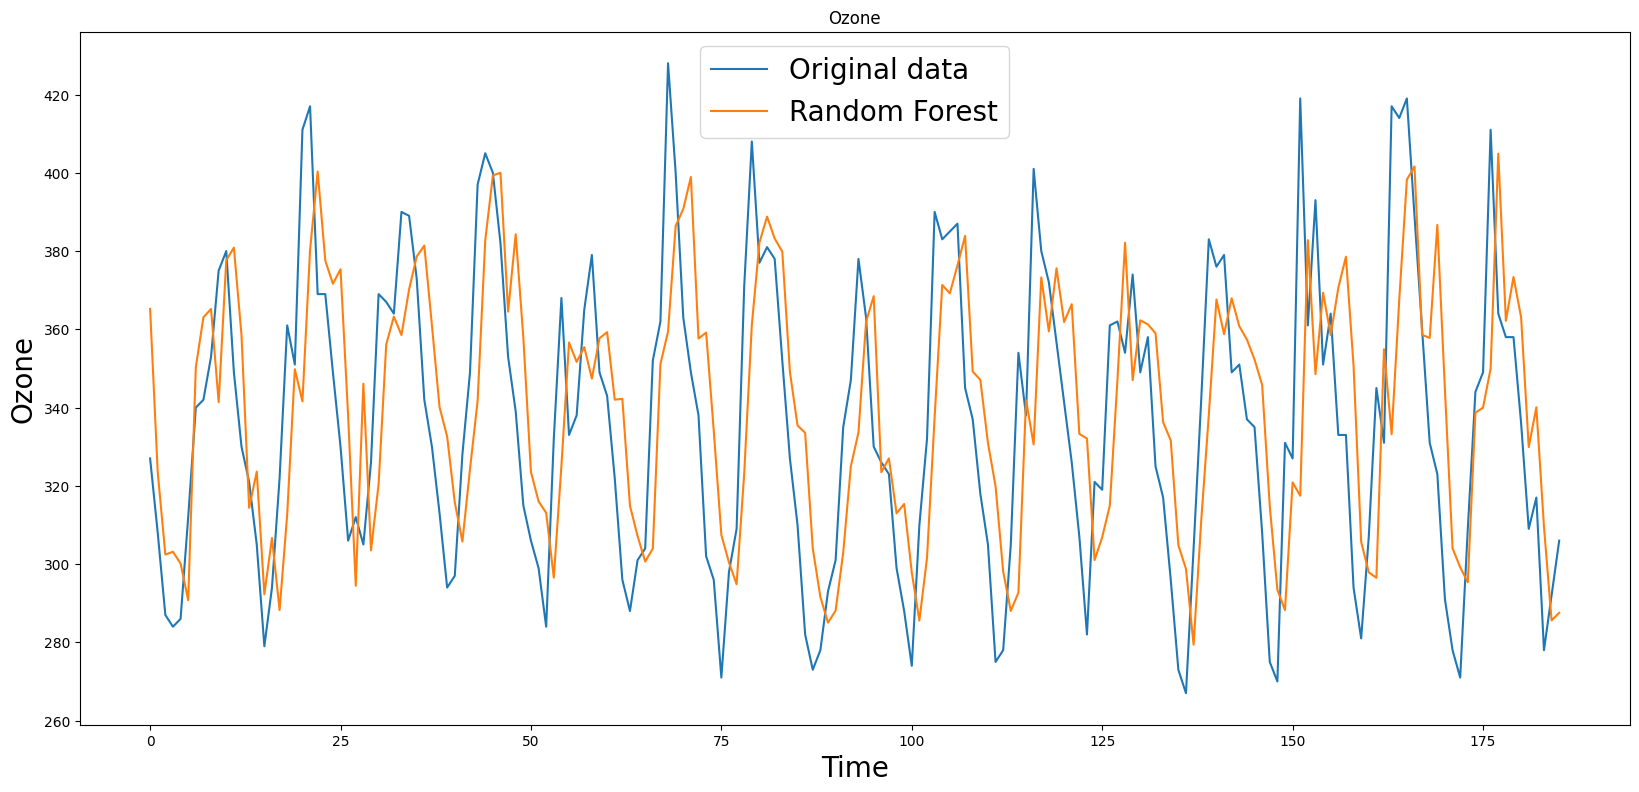

In [12]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Ozone')
plt.ylabel('Ozone', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [13]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

In [14]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 41.8250538008982
MAPE: 0.10317392541172872
MAE: 34.77598566308244
R2:  -0.19811863692474563


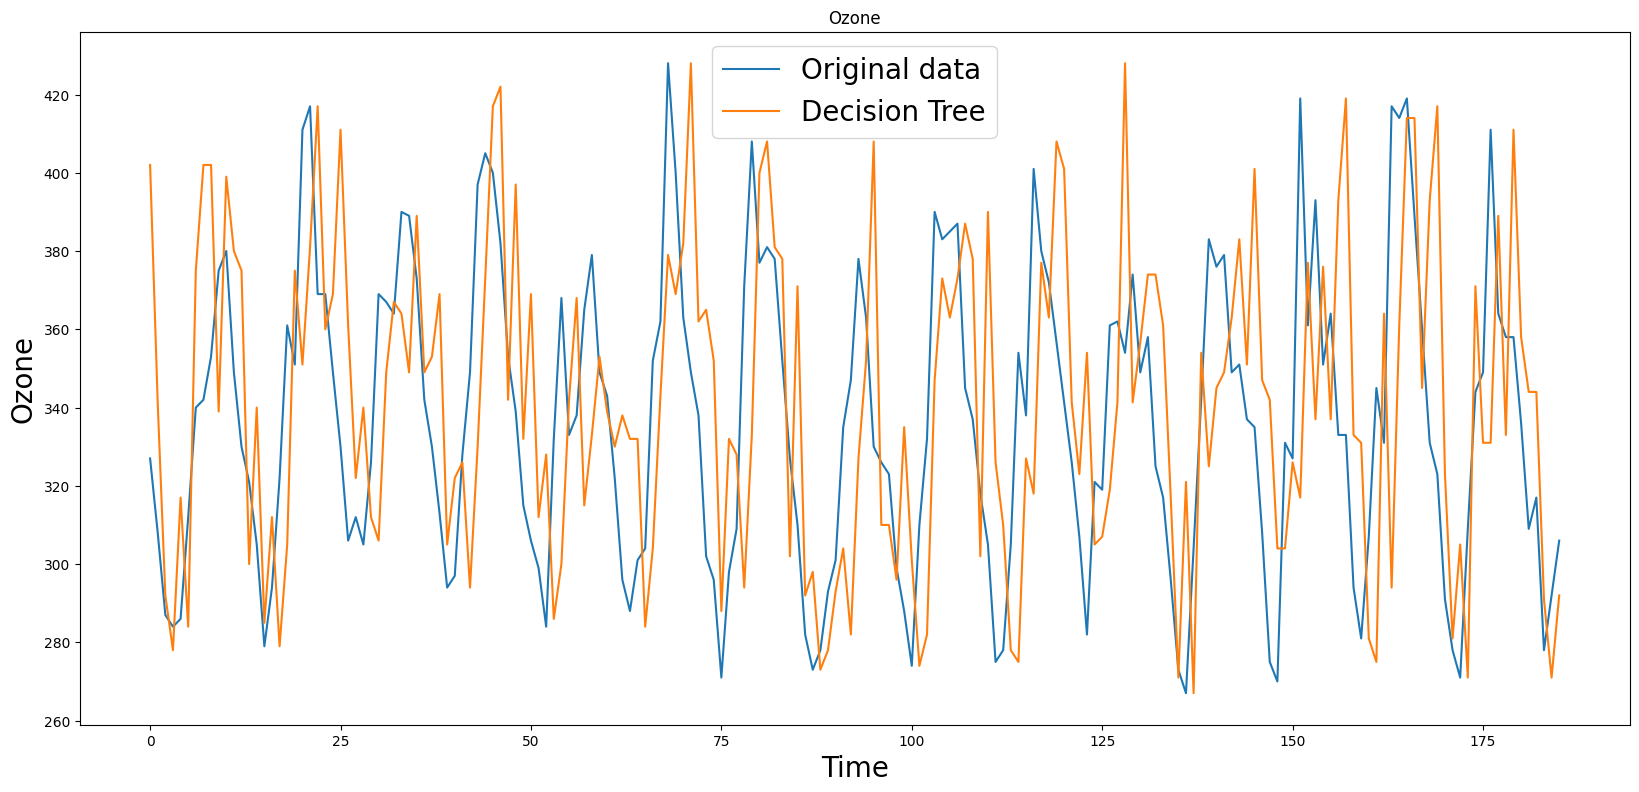

In [15]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Ozone')
plt.ylabel('Ozone', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
model = IsolationForest(contamination=0.004)
model.fit(ozone_csv[['x']])

IsolationForest(contamination=0.004)

In [18]:
ozone_csv["outliers"] = pd.Series([["no", "yes"][x == -1] for x in model.predict(ozone_csv[["x"]])])

C:\Users\Иван\AppData\Local\Temp\ipykernel_16644\1591674554.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ozone_csv["outliers"] = pd.Series([["no", "yes"][x == -1] for x in model.predict(ozone_csv[["x"]])])


In [19]:
ozone_csv['x'][ozone_csv["outliers"] == "yes"]

165    430.0
328    266.0
428    428.0
Name: x, dtype: float64

In [26]:
fig = px.scatter(ozone_csv.reset_index(), x='t', y='x', color='outliers')
fig.update_xaxes(rangeslider_visible=True)
fig.show()